# ==================================================
# S2 (Direct-Recursive Strategy)
# M1 (LGBM)
# Standard Code _ Version 1.0 / KISLAB @ Kookmin University
# ==================================================

# Basic Options (for Extended Experiment)

In [1]:
# 기본 설정값
SMCODE = "S2M1"    # S2(Direct-Recursive Strategy) + M1(LGBM) 를 위한 Standard Code
PDCODE = "ONI"     # 품종코드
MDCODE = "LGBM"     # 모델코드
PDNAME = "Onion"   # 품종명(영문)
VARS = 2           # 확장변수 사용여부 (1: 가격만 사용, 2: 거래량 추가사용)

# 학습 기본변수 설정
PARAMS = {'num_leaves': 100,
  'min_child_weight': 0.034,
  'feature_fraction': 0.379,
  'bagging_fraction': 0.418,
  'min_data_in_leaf': 106,
  'objective': 'regression',
  'max_depth': -1,
  'learning_rate': 0.005,
  "boosting_type": "gbdt",
  "bagging_seed": 11,
  "metric": 'rmse',
  "verbose": -1,
  'reg_alpha': 0.3899,
  'reg_lambda': 0.648,
  'random_state': 222,
 }
ITER = 500       # LGBM의 학습 반복 횟수

# Special Option 설정
IRANGE = 365   # 가격 데이터를 입력으로 사용할 때 최대 총 며칠치 데이터를 사용할 것인지에 대한 옵션
WINSOR = 10   # 이상치 제거를 위한 Winsorizing 기준 설정 (단위: 퍼센트 / 이 값이 0일 경우, 이상치 제거 안함)

#BASEDATE = '2021-01-01'   # 검증용 데이터의 시작 시점 (D1을 위한 설정)
#USEDATE = '2021-12-31'    # 전체 사용할 데이터의 마지막 시점 (D1을 위한 설정)
BASEDATE = '2022-01-01'   # 검증용 데이터의 시작 시점 (D2를 위한 설정)
USEDATE = '2022-07-29'    # 전체 사용할 데이터의 마지막 시점 (D2를 위한 설정)

SELECTED = [5]    # 예측모델을 개발할 선택 시점
NSEL = len(SELECTED)    # 예측모델을 개발할 선택 시점의 총 갯수


# ========= 결과 저장용 폴더 생성 ============== 

# System related and data input controls
import os

MODEL_DIR = 'MODEL_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE
SCALE_DIR = 'SCALE_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE

if os.path.exists(MODEL_DIR) == False:
    os.mkdir(f'{MODEL_DIR}')

if os.path.exists(SCALE_DIR) == False:
    os.mkdir(f'{SCALE_DIR}')

# ============= 데이터셋 로드 ================  

# Ignore the warnings
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd

#load data
raw = pd.read_excel('(140103-220728)양파(양파(일반)).xlsx', usecols=['일자', '품종', '거래량(톤)', '도매가격(원/kg)'])
# raw = raw[raw['품종']=='양파(일반)']

#create 'datetime' column
if '일자' in raw.columns:
    raw['일자'] = pd.to_datetime(raw['일자'])
    raw['DateTime'] = pd.to_datetime(raw['일자'])

#set datetime to index 
if raw.index.dtype == 'int64':
    raw.set_index('DateTime',inplace=True)

raw.drop (['품종', '일자'], axis=1, inplace=True)
raw.columns = ['Price', 'Volume']
for i in range(0, raw.shape[0]):
    raw['Volume'][i] = raw['Volume'][i].replace(',','')
raw['Volume'] = raw['Volume'].astype('float32')

#fill missing date & values
raw.asfreq('D')[raw.asfreq('D').isnull().sum(axis=1) > 0]
raw = raw.asfreq('D', method='ffill')

# Load Library

In [2]:
# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Regression
from lightgbm import LGBMRegressor as lgb
import lightgbm as lgb

# Evaluation metrics for regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib
import tensorflow as tf

import datetime

In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import keras

# Feature Engineering code

In [4]:
### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')
    raw['Price'].fillna(method='ffill',inplace=True)

    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['Price_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['Price_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'Price_trend' not in raw.columns:
        if 'Price_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    # STL분해 중 잔차 구하기
    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive',period=30,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['Price_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = (raw.index.quarter)
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season'],axis=1,inplace=True)
    
    #가격 관련 변수 추가
    raw['rolling_mean_t30'] = raw['Price'].transform(lambda x: x.ewm(span=30,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t90'] = raw['Price'].transform(lambda x: x.ewm(span=90,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t180'] = raw['Price'].transform(lambda x: x.ewm(span=180,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t270'] = raw['Price'].transform(lambda x: x.ewm(span=270,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t365'] = raw['Price'].transform(lambda x: x.ewm(span=365,min_periods=1,adjust=True,ignore_na=False).mean())
    
    #for a in range(1,366):
    #    raw[f'Price_lag{a}'] = raw['Price'].shift(a)
    #    raw[f'Price_lag{a}'].fillna(0,inplace=True)
    
    raw['P_diff']=raw['Price'].diff(1)
    raw['P_diff'].fillna(0,inplace=True)
#    raw['Year_a_go'] = raw['Price'].shift(365)
#    raw['Y_diff'] = raw['Price']-raw['Year_a_go']
    raw['P_sum'] = raw['Price']+raw['P_diff']

    raw['month'] =(raw['month'] + (raw.year - raw.year.min()) * 12)
    mapd = raw.groupby('month')['Price'].mean()
    mapd = pd.DataFrame(mapd,index=mapd.index)  
    mapd.reset_index(drop=False,inplace=True)
    mapd.columns=['month','Mapd']
    raw = pd.merge(raw,mapd,how='left',left_on='month',right_on='month')
    raw['R_p'] = raw['Price']-raw['Mapd']
    
    raw.drop(['Mapd'],axis=1,inplace=True)
    
    return raw

# Data Partitioning

In [5]:
# Raw dataset selection
raw=raw[raw.index <= USEDATE]

# Train,Test split
test=raw[raw.index >= BASEDATE]
train=raw[raw.index < BASEDATE]
raw_idx = raw.index
train_idx = train.index

df = raw.copy()
df = df[['Volume', 'Price']]

VS = df.copy()
VS = VS.drop(['Price'], axis=1)
VS['Volume'] = VS['Volume'].shift(1)

y_test = test['Price']

# LGBM with FE

In [6]:
with tf.device("/device:CPU:0"):
    
    for day_num in tqdm(range(1, 1 + max(SELECTED))):

        if day_num == 1:
                        
            train_all = []
            train_all = raw.iloc[:,:1]

            # Price에 Outlier Treatment 적용 ---------------------#

            winsor_list = []
            winsor_list.append(WINSOR)
            winsor_list.append(100 - WINSOR)

            winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
            winsor_min = winsors[0]
            winsor_max = winsors[1]

            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])

            #-----------------------------------------------------#

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + day_num):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            raw_all = train_all.iloc[day_num:]
            raw_seed = raw_all.iloc[:,1:2]
            raw_seed.columns=['Price']
            raw_seed = feature_engineering(raw_seed)
            seed = raw_seed.iloc[:,1:]
            seed.index = raw_idx[day_num:]

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([raw_all, seed, V['Volume']],axis=1)
            else:
                raw_final = pd.concat([raw_all, seed],axis=1)

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]

            y_train_raw = train_new['Price']
            x_train_raw = train_new.drop(['Price'],axis=1)   

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.save')
                        
            x_train = X_train
            y_train = y_train_raw            

            # LGBM Training

            dtrain = lgb.Dataset(x_train, label=y_train)        
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)

            # Save model
            joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.pkl')
                        
            # Prediction
            Y_train_pred = model.predict(x_train)

        else:

            train_all = []
            train_all = raw.iloc[:,:1]

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + 1):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            train_new = train_new.iloc[:,:day_num-1]

            for call_train in range(1, day_num-1):
                train_new[f'Y_{call_train}pred'] = train_new[f'Y_{call_train}pred'].shift(1)

            train_new[f'Y_{day_num-1}pred'] = 0
            train_new[f'Y_{day_num-1}pred'] = Y_train_pred
            train_new[f'Y_{day_num-1}pred'] = train_new[f'Y_{day_num-1}pred'].shift(1)

            new = train_new.columns[-1:].to_list()
            Price = train_new.columns[:1].to_list()
            old = train_new.columns[1:day_num-1].to_list()
            new_col = Price + new + old
            train_new = train_new[new_col]

            train_new.fillna(method='bfill',inplace=True)

            raw_all = train_all.iloc[day_num:]
            raw_seed = raw_all.iloc[:,1:2]
            raw_seed.columns=['Price']
            raw_seed = feature_engineering(raw_seed)
            seed = raw_seed.iloc[:,1:]
            seed.index = raw_idx[day_num:]

            train_all = train_all.drop('Price', axis=1)

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([train_new, train_all, seed, V['Volume']],axis=1)
            else:
                raw_final = pd.concat([train_new, train_all, seed],axis=1)

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]        

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.save')
                        
            x_train = X_train
            y_train = y_train_raw            

            # LGBM Training

            dtrain = lgb.Dataset(x_train, label=y_train)        
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)

            # Save model
            joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.pkl')    


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.11s/it]


# LGBM with FE / Inference

In [7]:
pred=[]

DCNT = test.shape[0]

pos = 0

# lag변수 생성 
for i in range(1, IRANGE + 1):
    df[f'Price{i}lag'] = df['Price'].shift(i)

with tf.device("/device:GPU:0"):  

    for day_num in tqdm(SELECTED):
        
        pos = pos + 1
        pred_list = []

        for valid_day in tqdm(range(0, DCNT)):
            
            target_date = test.index[0] + datetime.timedelta(days = -day_num + valid_day)
            df_x = df.iloc[df.index <= target_date, 2:]
            seed = df_x.iloc[:, 0:1]
            seed.columns=['Price']
            seed.fillna(method='bfill', inplace=True)
            df_fe = feature_engineering(seed)
            df_fe.index = df_x.index 

            V = VS[VS.index == target_date]
            
            for model_day in range(1, day_num + 1):                
                
                if model_day == 1:

                    test_old = df_x[-1:]
                    test_new = df_fe[-1:].drop('Price', axis=1)

                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_old, test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_old, test_new],axis=1)

                    scaler = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{model_day}.save')
                    x_test = scaler.transform(raw_final)

                    load_model = joblib.load(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{model_day}.pkl')
                    y_test_pred = load_model.predict(x_test)

                    temp = raw_final.iloc[:, 0:IRANGE]                    
                                        
                else:
                    
                    temp.index = temp.index + datetime.timedelta(days=1)

                    for mov in range(IRANGE, 2, -1):
                        temp[f'Price{mov}lag'] = temp[f'Price{mov-1}lag']

                    temp['Price1lag'] = y_test_pred
                    df_x = df_x.append(temp)

                    seed = df_x.iloc[:, 0:1]
                    seed.columns=['Price']
                    seed.fillna(method='bfill', inplace=True)
                    df_fe = feature_engineering(seed)
                    df_fe.index = df_x.index

                    test_old = df_x[-1:]
                    test_new = df_fe[-1:].drop('Price', axis=1)
                    V.index = temp.index

                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_old, test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_old, test_new],axis=1)

                    scaler = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{model_day}.save')
                    x_test = scaler.transform(raw_final)

                    load_model = joblib.load(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{model_day}.pkl')
                    y_test_pred = load_model.predict(x_test)
            
            pred_list.append(y_test_pred[0])

        pred.append(pred_list) 

 30%|████████████████████████▋                                                        | 64/210 [00:55<02:07,  1.15it/s]


 62%|█████████████████████████████████████████████████▌                              | 130/210 [01:53<01:10,  1.14it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 196/210 [02:50<00:12,  1.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:03<00:00, 183.03s/it]


# LGBM with FE / Visualization

Model5 Results



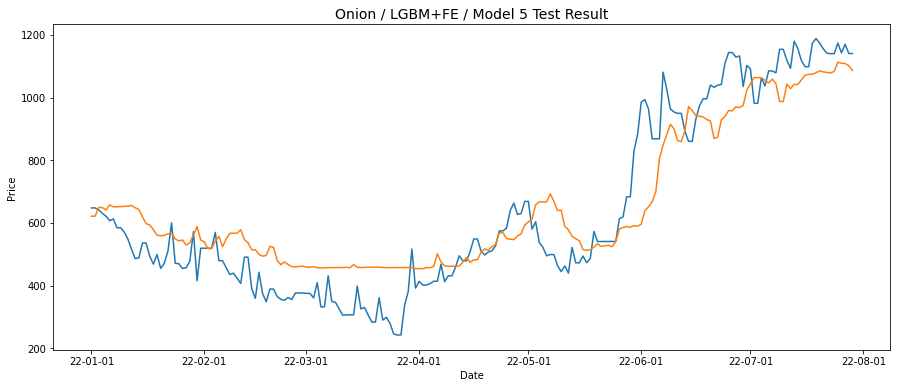

MAPE=17.698586353881122
RMSE=111.28363400412182





<Figure size 432x288 with 0 Axes>

In [8]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + '+FE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')

# LGBM without FE

In [9]:
with tf.device("/device:CPU:0"):
    
    for day_num in tqdm(range(1, 1 + max(SELECTED))):

        if day_num == 1:
                        
            train_all = []
            train_all = raw.iloc[:,:1]

            # Price에 Outlier Treatment 적용 ---------------------#

            winsor_list = []
            winsor_list.append(WINSOR)
            winsor_list.append(100 - WINSOR)

            winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
            winsor_min = winsors[0]
            winsor_max = winsors[1]

            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])

            #-----------------------------------------------------#

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + day_num):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            raw_all = train_all.iloc[day_num:]

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([raw_all,V['Volume']],axis=1)
            else:
                raw_final = raw_all

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]

            y_train_raw = train_new['Price']
            x_train_raw = train_new.drop(['Price'],axis=1)   

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.save')
                        
            x_train = X_train
            y_train = y_train_raw            

            # LGBM Training

            dtrain = lgb.Dataset(x_train, label=y_train)        
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)

            # Save model
            joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.pkl')
                        
            # Prediction
            Y_train_pred = model.predict(x_train)

        else:

            train_all = []
            train_all = raw.iloc[:,:1]

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + 1):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            train_new = train_new.iloc[:,:day_num-1]

            for call_train in range(1, day_num-1):
                train_new[f'Y_{call_train}pred'] = train_new[f'Y_{call_train}pred'].shift(1)

            train_new[f'Y_{day_num-1}pred'] = 0
            train_new[f'Y_{day_num-1}pred'] = Y_train_pred
            train_new[f'Y_{day_num-1}pred'] = train_new[f'Y_{day_num-1}pred'].shift(1)

            new = train_new.columns[-1:].to_list()
            Price = train_new.columns[:1].to_list()
            old = train_new.columns[1:day_num-1].to_list()
            new_col = Price + new + old
            train_new = train_new[new_col]

            train_new.fillna(method='bfill',inplace=True)

            raw_all = train_all.iloc[day_num:]

            train_all = train_all.drop('Price', axis=1)

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([train_new, train_all, V['Volume']],axis=1)
            else:
                raw_final = pd.concat([train_new, train_all],axis=1)

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]        

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.save')
                        
            x_train = X_train
            y_train = y_train_raw            

            # LGBM Training

            dtrain = lgb.Dataset(x_train, label=y_train)        
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)

            # Save model
            joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.pkl')    


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


# LGBM without FE / Inference

In [10]:
pred=[]

DCNT = test.shape[0]

pos = 0

# lag변수 생성 
for i in range(1, IRANGE + 1):
    df[f'Price{i}lag'] = df['Price'].shift(i)

with tf.device("/device:GPU:0"):  

    for day_num in tqdm(SELECTED):
        
        pos = pos + 1
        pred_list = []

        for valid_day in tqdm(range(0, DCNT)):
            
            target_date = test.index[0] + datetime.timedelta(days = -day_num + valid_day)
            df_x = df.iloc[df.index <= target_date, 2:]

            V = VS[VS.index == target_date]
            
            for model_day in range(1, day_num + 1):                
                
                if model_day == 1:

                    test_new = df_x[-1:]
                    
                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_new],axis=1)

                    scaler = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{model_day}.save')
                    x_test = scaler.transform(raw_final)

                    load_model = joblib.load(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{model_day}.pkl')
                    y_test_pred = load_model.predict(x_test)

                    temp = raw_final.iloc[:, 0:IRANGE]                    
                                        
                else:
                    
                    temp.index = temp.index + datetime.timedelta(days=1)

                    for mov in range(IRANGE, 2, -1):
                        temp[f'Price{mov}lag'] = temp[f'Price{mov-1}lag']

                    temp['Price1lag'] = y_test_pred
                    df_x = df_x.append(temp)

                    test_new = df_x[-1:]
                    V.index = temp.index

                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_new],axis=1)

                    scaler = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{model_day}.save')
                    x_test = scaler.transform(raw_final)

                    load_model = joblib.load(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{model_day}.pkl')
                    y_test_pred = load_model.predict(x_test)
            
            pred_list.append(y_test_pred[0])

        pred.append(pred_list) 

 30%|████████████████████████▋                                                        | 64/210 [00:41<01:35,  1.54it/s]


 62%|█████████████████████████████████████████████████▌                              | 130/210 [01:25<00:54,  1.48it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 196/210 [02:09<00:09,  1.51it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.89s/it]


# LGBM without FE / Visualization

Model5 Results



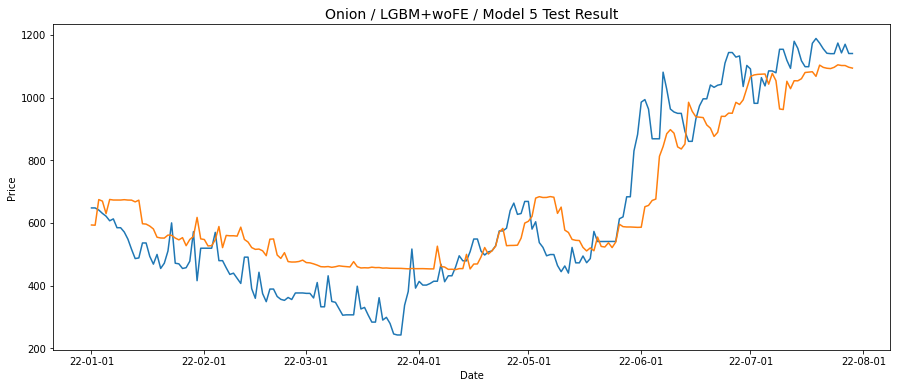

MAPE=18.59439238004014
RMSE=115.29444618964935





<Figure size 432x288 with 0 Axes>

In [11]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + '+woFE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')